# Notebook de simulation afin de déterminer la fréquence nécessaire de mise à jour

# Sommaire:


**Objectif**

**<a href="#C1">I) Importation des librairies</a>**

**<a href="#C2">II) Création des dataframes principaux (commandes et clients)</a>**
&nbsp;

**<a href="#C3">III) Création du Pipeline de modélisation</a>**
&nbsp;

**<a href="#C4">IV) Création du dataframe à t0</a>**
&nbsp;

**<a href="#C5">V) Détermination de la période de maintenance</a>**
&nbsp;


***

# **Objectif**

L'objectif de cette étape est de déterminer le temps à partir duquel le modèle est obsolète (mauvais cluster) et devra être ré-entraîné. Ce temps sera désigné sout le nom de période de maintenance

L'algorithme utilisé pour déterminer la periode de maintenance est quasiment similaire à celui de la stabilité. 

Pour ce faire, les clusters calculés chaque semaine seront prédits à partir du modèle entrainé à t26. 
- Entraînement du modèle sur la semaine T26
- Prédiction des cluster Tn sur le modèle entrainé en T26
- comparaison des clusters entre T26 et Tn avec l'index ajusté de Rand

# <a name="C1"> I) Importation des librairies</a>

In [5]:
# Librairies de base
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from functools import reduce

# pre-processing
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

# pipeline
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# modèle
from sklearn.cluster import KMeans

# métrique
from sklearn.metrics import adjusted_rand_score

# <a name="C2"> II) Création des dataframes principaux (commandes et clients)</a>

In [7]:
# Importation des données
olist_customers_dataset = pd.read_csv(r"C:\Users\elodi\Downloads\Test\olist_customers_dataset.csv", usecols=[
                                      'customer_id', 'customer_unique_id', 'customer_state'])
olist_orders_dataset = pd.read_csv(r"C:\Users\elodi\Downloads\Test\olist_orders_dataset.csv", usecols=[
                                   'order_id', 'customer_id', 'order_status', 'order_purchase_timestamp',
                                   'order_approved_at', 'order_delivered_customer_date', 'order_estimated_delivery_date'])
olist_order_items_dataset = pd.read_csv(r"C:\Users\elodi\Downloads\Test\olist_order_items_dataset.csv", usecols=[
                                        'order_id', 'price', 'product_id', 'order_item_id'])
olist_order_reviews_dataset = pd.read_csv(
    r"C:\Users\elodi\Downloads\Test\olist_order_reviews_dataset.csv", usecols=['order_id', 'review_score'])
olist_order_payments_dataset = pd.read_csv(
    r"C:\Users\elodi\Downloads\Test\olist_order_payments_dataset.csv", usecols=['order_id', 'payment_type'])


# Jointure des données
dfs_orders = [olist_orders_dataset,
              olist_order_items_dataset, olist_order_reviews_dataset]
df_full = reduce(lambda left, right: pd.merge(
    left, right, on='order_id', how='outer'), dfs_orders)
df_full = pd.merge(df_full, olist_customers_dataset,
                   on='customer_id', how='outer')

# Filtre des commandes annulées
df_full = df_full[(df_full.order_status != 'canceled') &
                  (df_full.order_status != 'unavailable')]

# Mise au format Datetime des colonnes de dates
lst_var_date = ['order_approved_at',
                'order_delivered_customer_date', 'order_estimated_delivery_date']

for var in lst_var_date:
    df_full[var] = pd.to_datetime(
        df_full[var], errors='coerce').dt.normalize()

# Création d'une colonne temps de livraison
df_full['Delivery_Time'] = (
    df_full['order_delivered_customer_date'] - df_full['order_approved_at']).dt.days

# Pour certaines valeurs, le temps de livraison est négatif
df_full['Delivery_Time'] = np.where(
    df_full['Delivery_Time'] < 0, 0, df_full['Delivery_Time'])

# Création du jeu de données par clients et par commande

# Suppression des commandes annulées et non disponible


df_Customers_order = df_full[['Delivery_Time',
                              'customer_unique_id',
                              'price',
                              'product_id',
                              'review_score',
                              'order_id',
                              'order_approved_at',
                              'customer_state'
                              ]]\
    .groupby(['customer_unique_id', 'order_id'])\
    .agg({'Delivery_Time': 'mean',
          'review_score': 'mean',
          'price': 'mean',
          'order_approved_at': 'max',
          'customer_state': 'max',
          'product_id': 'count'})

df_Customers_order['Sum_tot'] = df_full[['customer_unique_id', 'order_id', 'price']].groupby(
    ['customer_unique_id', 'order_id']).agg('sum')
df_Customers_order = df_Customers_order.reset_index()

# Création du jeu de données par clients
df_Customers = df_Customers_order.groupby('customer_unique_id')\
    .agg({'Delivery_Time': 'mean',
          'review_score': 'mean',
          'order_approved_at': 'min',
          'Sum_tot': 'sum'}).round(2)

df_Customers.columns = ['mean_delivery_time',
                        'mean_review_score',
                        'first_order',
                        'total_expanse']

# Date de la dernière commande
df_Customers['last_order'] = df_Customers_order.groupby(
    'customer_unique_id').agg({'order_approved_at': 'max'})

# Récence (date du jour - date du dernier achat)
df_Customers['recency'] = (
    df_Customers["last_order"].max() - df_Customers['last_order']).dt.days

# nombre de commande totale
df_Customers['nb_order'] = df_Customers_order.groupby(
    'customer_unique_id').agg({'order_id': 'count'})

# nombre moyen d'article par panier
df_Customers['mean_nb_item'] = df_Customers_order.groupby(
    'customer_unique_id').agg({'product_id': 'mean'}).round(2)

# <a name="C3"> III) Création du Pipeline de modélisation</a>

In [9]:
from sklearn import set_config
features = ['mean_review_score',
            'nb_order',
            'mean_nb_item']


log_features = ['mean_delivery_time',
                'total_expanse',
                'recency']

features_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")),
           ("scaler", StandardScaler())]
)

logfeatures_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")),
           ("logTransformation", FunctionTransformer(
               lambda value: np.log1p(value))),
           ("scaler", StandardScaler())]
)


preprocessor = ColumnTransformer(
    transformers=[
        ("features", features_transformer, features),
        ("log_features", logfeatures_transformer, log_features),
    ]
)

model_pipeline = Pipeline(steps=[('pre_processing', preprocessor),
                                 ('kmeans', KMeans(random_state=0, n_clusters=6))
                                 ])

set_config(display="diagram")
model_pipeline

Pipeline(steps=[('pre_processing',
                 ColumnTransformer(transformers=[('features',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['mean_review_score',
                                                   'nb_order',
                                                   'mean_nb_item']),
                                                 ('log_features',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('logTransformation',
                                                                   FunctionTransformer(func=<function <lambda> at 0x0000022150782E80>)),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['mean_delivery_time',
                                                   'total_expanse',
                                                   'recency'])])),
                ('kmeans', KMeans(n_clusters=6, random_state=0))])

# <a name="C4"> IV) Création du dataframe à t0</a>

In [11]:
# récupération des indes des clients présents du début à la fin de la periode d'analyse
Index_df_full = df_Customers[df_Customers['first_order'] <
                             df_Customers['last_order'].max() - pd.DateOffset(weeks=26)].index

# Création du df pour le calcul de l'ARI
df_ARI = df_Customers_order.loc[df_Customers_order['customer_unique_id'].isin(
    Index_df_full)].copy()

In [12]:
# Dataframe at t26, 26 weeks ~5 months :
time_export = (df_Customers['last_order'].max() -
               pd.DateOffset(weeks=26)).strftime("%Y-%m-%d")
df_temp_order = df_ARI[df_ARI['order_approved_at'] < time_export]


df_temp_customer = df_temp_order.groupby('customer_unique_id')\
    .agg({'Delivery_Time': 'mean',
          'review_score': 'mean',
          # 'price': 'mean',
          'order_approved_at': 'min',
          'Sum_tot': 'sum'}).round(2)

df_temp_customer.columns = ['mean_delivery_time',
                            'mean_review_score',
                            'first_order',
                            'total_expanse']

# Date de la dernière commande
df_temp_customer['last_order'] = df_temp_order.groupby(
    'customer_unique_id').agg({'order_approved_at': 'max'})

# Recency : (date du jour - date du dernier achat)
df_temp_customer['recency'] = (
    df_temp_customer["last_order"].max() - df_temp_customer['last_order']).dt.days

# Nb_order : nombre de commande totale
df_temp_customer['nb_order'] = df_temp_order.groupby(
    'customer_unique_id').agg({'order_id': 'count'})

# Mean_nb_item : nombre moyen d'article par panier
df_temp_customer['mean_nb_item'] = df_temp_order.groupby(
    'customer_unique_id').agg({'product_id': 'mean'}).round(2)

df_t0 = df_temp_customer

# <a name="C5"> V) Détermination de la période de maintenance</a>

In [14]:
# Création du dataframe avec les prédictions du début de l'analyse (t26)
clusters_weeks = pd.DataFrame(
    model_pipeline.fit_predict(df_t0), columns=[time_export])

clusters_weeksT0 = pd.DataFrame(
    model_pipeline.predict(df_t0), columns=[time_export])

In [15]:
for week in range(25, -1, -1):
    # sauvegarde du temps de l'export :
    time_export = (df_Customers['last_order'].max(
    ) - pd.DateOffset(weeks=week)).strftime("%Y-%m-%d")

    # création du dataframe contenant toutes les ventes de la première vente à la dernièrevente - semaine :
    df_temp_order = df_ARI[df_ARI['order_approved_at'] < time_export]

    # création du dataframe regroupé par client
    df_temp_customer = df_temp_order.groupby('customer_unique_id')\
        .agg({'Delivery_Time': 'mean',
              'review_score': 'mean',
              'order_approved_at': 'min',
              'Sum_tot': 'sum'}).round(2)

    df_temp_customer.columns = ['mean_delivery_time',
                                'mean_review_score',
                                'first_order',
                                'total_expanse']

    # Date de la dernière commande
    df_temp_customer['last_order'] = df_temp_order.groupby(
        'customer_unique_id').agg({'order_approved_at': 'max'})

    # Recency : (date du jour - date du dernier achat)
    df_temp_customer['recency'] = (
        df_temp_customer["last_order"].max() - df_temp_customer['last_order']).dt.days

    # Nb_order : nombre de commande totale
    df_temp_customer['nb_order'] = df_temp_order.groupby(
        'customer_unique_id').agg({'order_id': 'count'})

    # Mean_nb_item : nombre moyen d'article par panier
    df_temp_customer['mean_nb_item'] = df_temp_order.groupby(
        'customer_unique_id').agg({'product_id': 'mean'}).round(2)

    # Entrainement du modèle sur le df au temps n et Prédiction des clusters : stablitié des cluster
    clusters_weeks[time_export] = model_pipeline.fit_predict(df_temp_customer)

    # Prédiction des clusters du df_tn avec le modèle entrainé en T0 (-26 semaines) : contrat de maintenance
    model_pipeline.fit(df_t0)
    clusters_weeksT0[time_export] = model_pipeline.predict(df_temp_customer)

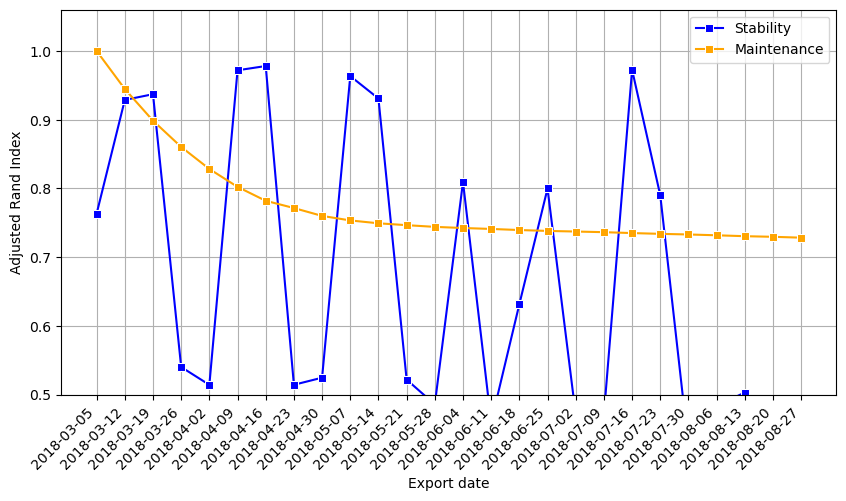

In [16]:
ARI_kmeans = []

ARI_kmeans2 = []


for col in range(0, 26):
    temp = adjusted_rand_score(
        clusters_weeks.iloc[:, col], clusters_weeks.iloc[:, col+1])
    ARI_kmeans.append(temp)

    temp = adjusted_rand_score(
        clusters_weeksT0.iloc[:, 0], clusters_weeksT0.iloc[:, col])
    ARI_kmeans2.append(temp)


ARI_kmeans_stability = pd.DataFrame(ARI_kmeans, columns=["ARI"])
ARI_kmeans_stability['date'] = list(clusters_weeks.columns)[:-1]


ARI_kmeans_maintenance = pd.DataFrame(ARI_kmeans2, columns=["ARI"])
ARI_kmeans_maintenance['date'] = list(clusters_weeksT0.columns)[:-1]

plt.figure(figsize=(10, 5), dpi=100)

sns.lineplot(data=ARI_kmeans_stability, x='date', y='ARI',
             marker="s", color='blue', label='Stability')
sns.lineplot(data=ARI_kmeans_maintenance, x='date', y='ARI',
             marker="s", color='orange', label='Maintenance')
plt.xlabel("Export date")
plt.xticks(rotation=45, ha='right')
plt.ylabel("Adjusted Rand Index")
plt.legend(frameon=True)
plt.ylim(0.5, 1.06)
plt.grid()
plt.show()